# Libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.datasets import (make_swiss_roll, make_s_curve)
from sklearn import datasets

In [2]:
from megaman.datasets import generate_megaman_manifold
from megaman.geometry import Geometry
from megaman.embedding import (Isomap, LocallyLinearEmbedding, LTSA, SpectralEmbedding)
from megaman.plotter import (plot_with_plotly, plot_embedding_with_plotly, 
                     plot_with_matplotlib, plot_embedding_with_matplotlib) 
from megaman.geometry.rmetric import RiemannMetric
from megaman.utils.covar_plotter import plot_cov_ellipse

## Megaman package structure

- **Datasets** class contains megaman dataset, S Curve, Hourglass dataset (noisy and noisefree)
- **Geometry** is the main class that will cache things like distance/adjacency, affinity, and laplacian 
- **Embedding** class contains four manifold learning methods: Isomap, LocallyLinearEmbedding, LTSA, SpectralEmbedding (Laplacian Eigenmaps)
- **Plotter** class contains four plot functions with plotly and matplotlib libraries

In the Geometry class, we can pass parameters & methods for three main components:

- *Adjacency*: an NxN (sparse) pairwise matrix indicating neighborhood regions 
- *Affinity*: an NxN (sparse) pairwise matrix insicated similarity between points 
- *Laplacian*: an NxN (sparse) pairwsie matrix containing geometric manifold information

These parameters can also be overwritten when using the individual calculation functions. For example, 

In [3]:
radius = 1.0
adjacency_method = 'cyflann'
adjacency_kwds = {'radius':radius} # ignore distances above this radius
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius} # A = exp(-||x - y||/radius^2) 
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius} # scaling ensures convergence to Laplace-Beltrami operator

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)

# Datasets

## Megaman data
The data consists of nearly 7000 points in eight dimensions. If we look at pairs of dimensions, we can see that there is some sort of regular structure within the data:

In [4]:
# from megaman.datasets import generate_megaman_manifold
X, color = generate_megaman_manifold(sampling=3, random_state=42)
print(X.shape)
print(X)

(6696, 8)
[[-0.12745345  2.17587378  0.29839891 ...  1.38625831 -0.41062549
   0.619495  ]
 [ 0.11178101  2.12161356  0.26710922 ...  1.45660476 -0.40042209
   0.81141113]
 [ 0.35677548  2.0679276   0.22872273 ...  1.47920328 -0.34215592
   1.01052029]
 ...
 [-0.35677548 -2.0679276  -0.22872273 ... -1.47920328  0.34215592
  -1.01052029]
 [-0.11178101 -2.12161356 -0.26710922 ... -1.45660476  0.40042209
  -0.81141113]
 [ 0.12745345 -2.17587378 -0.29839891 ... -1.38625831  0.41062549
  -0.619495  ]]


In [5]:
# pairwise plot
def pairwise_grid(X, labels=None):
    N = X.shape[1]
    if labels is None:
        labels = ['X{0}'.format(i) for i in range(N)]
    fig, ax = plt.subplots(N, N, figsize=(8, 8),
                           sharex='col', sharey='row')
    for i in range(N):
        for j in range(N):
            ax[j, i].scatter(X[:, i], X[:, j], c=color, lw=0.5)
            if j == N - 1:
                ax[j, i].set_xlabel(labels[i])
            if i == 0:
                ax[j, i].set_ylabel(labels[j])

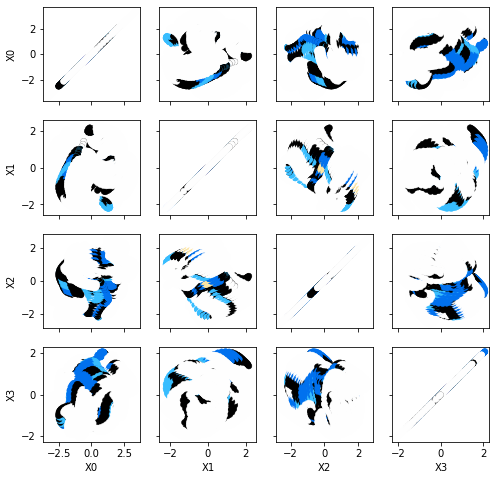

In [6]:
pairwise_grid(X[:, :4])

### Linear embedding: PCA

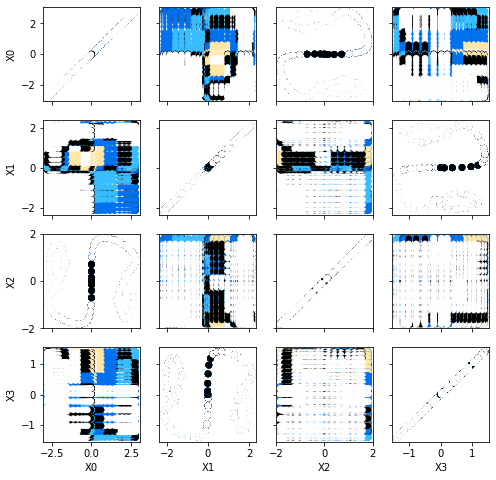

In [7]:
# compute the first four principal components and plot their pairwise relationships
X_pca = PCA(4).fit_transform(X)
pairwise_grid(X_pca)

### Nonliner embedding: LTSA

In [8]:
geom = Geometry(adjacency_kwds=dict(n_neighbors=6))
model = LTSA(geom=geom, eigen_solver='arpack', random_state=6)

X_ltsa = model.fit_transform(X)

In [9]:
print(X_ltsa.shape)
print(X_ltsa)

(6696, 2)
[[ 0.02095421  0.02082466]
 [ 0.02094499  0.02038114]
 [ 0.02093487  0.01993501]
 ...
 [-0.02100488 -0.02000376]
 [-0.02101505 -0.02045208]
 [-0.02102427 -0.02089788]]


In [10]:
print(geom)
print(model)

AttributeError: 'LTSA' object has no attribute 'max_iter'

### 2D plot of the LTSA-projected embedding

(-0.025, 0.025, 0.025, -0.025)

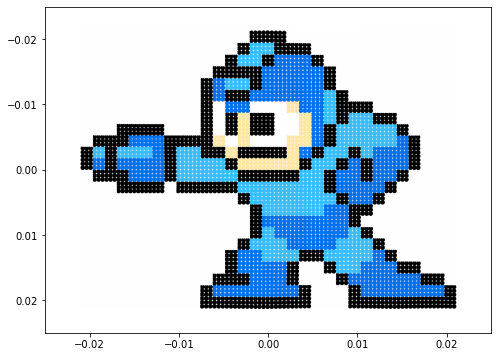

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_ltsa[:, 1], X_ltsa[:, 0], c=color, s=20, lw=0.1)
ax.axis([-0.025, 0.025, 0.025, -0.025])

## 3-D S curve data and Swiss Roll data

In [12]:
# from sklearn import datasets
N = 1000
# X, color = make_s_curve(N, random_state=0)
X, color = make_swiss_roll(N) ## Swiss Roll dataset
print(X)

[[ 6.34960185 11.78043512  1.36953518]
 [ 4.4962144  18.94066398 -3.3982779 ]
 [ 2.22648804 19.48699968 -4.65343907]
 ...
 [-5.67707409 13.9037103  -8.73691964]
 [10.81762758 16.67158347 -5.42462469]
 [12.27903741 13.64953783 -1.84655608]]


### Plot 3-d S curve data

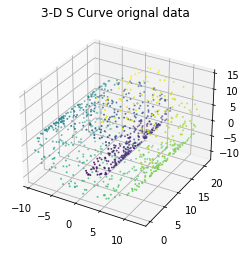

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=color, s = 1)
plt.title('3-D S Curve orignal data')
plt.show()

### Initialize Geometry class

In [14]:
radius = 1.0
adjacency_method = 'cyflann'
adjacency_kwds = {'radius':radius} # ignore distances above this radius
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius} # A = exp(-||x - y||/radius^2) 
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius} # scaling ensures convergence to Laplace-Beltrami operator

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)

### Inputing Data to Geometry

- set_data_matrix(): input an (n_observation X n_dimensions) array of data points
- set_adjacency_matrix(): input an (n_observation X n_observation) pairwise (sparse) matrix indicating neighborhoods distances. This matrix should be sparse with zero entries considered Infinite. The diagonal is considered explicitly zero when calculating an affinity matrix.
- set_affinity_matrix(): input an (n_observation X n_observation) pairwise (sparse) indicating similarity between points. High values indicate strong degree of similarity, the diagonal should take on the maximum value in its row.

In [15]:
geom.set_data_matrix(X)

### Computing geometric matrices

In [16]:
adjacency_matrix = geom.compute_adjacency_matrix()
print(adjacency_matrix)

  (0, 0)	0.0
  (0, 109)	0.52620375
  (0, 551)	0.8018395
  (1, 1)	0.0
  (1, 447)	0.6781291
  (1, 459)	0.6805988
  (1, 650)	0.7392061
  (1, 783)	0.9003067
  (2, 2)	0.0
  (2, 857)	0.60400826
  (2, 683)	0.83813167
  (2, 102)	0.8549235
  (2, 414)	0.9519297
  (2, 787)	0.96793157
  (3, 3)	0.0
  (3, 801)	0.8521039
  (4, 4)	0.0
  (4, 680)	0.40037444
  (4, 58)	0.44152611
  (5, 5)	0.0
  (5, 948)	0.5136352
  (5, 976)	0.808584
  (6, 6)	0.0
  (7, 7)	0.0
  (7, 290)	0.458428
  :	:
  (986, 986)	0.0
  (986, 897)	0.40287718
  (986, 258)	0.8546755
  (987, 987)	0.0
  (987, 826)	0.6932885
  (988, 988)	0.0
  (989, 989)	0.0
  (989, 452)	0.52965826
  (989, 434)	0.90014076
  (990, 990)	0.0
  (990, 150)	0.9977288
  (991, 991)	0.0
  (991, 977)	0.76598376
  (992, 992)	0.0
  (993, 993)	0.0
  (994, 994)	0.0
  (994, 723)	0.79687274
  (995, 995)	0.0
  (995, 678)	0.6728566
  (996, 996)	0.0
  (996, 653)	0.30005106
  (997, 997)	0.0
  (998, 998)	0.0
  (998, 87)	0.66334337
  (999, 999)	0.0


In [17]:
# Radius selection
from scipy.sparse.csgraph import connected_components

rad1 = 3.5 # choose a small radius to start, but result in a fully connected graph
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':rad1}
adjacency_matrix = geom.compute_adjacency_matrix()
# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius':rad1}
affinity_matrix = geom.compute_affinity_matrix({'radius':rad1})
(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components) # 1 means fully connected graph

1


### Embedding

The Isomap class functions as follows:

- An existing Geometry object can be passed to .Isomap().
 
- The .fit() method creates a Geometry object if one was not already passed and then calculates th embedding. 
    
    The number of components and eigen solver can also be passed to the .fit() function. The .fit() function for Isomap  does not return anything but it does create the attribute self.embedding_. 

- The .fit_transform() function calls the fit() function and returns the embedding. It does not allow for changing parameters.

In [18]:
# select output dimension
n_components = 2

In [19]:
# four embedding methods
isomap = Isomap(n_components=n_components, eigen_solver='arpack',geom=geom)
embed_isomap = isomap.fit_transform(X)

lle = LocallyLinearEmbedding(n_components=n_components, eigen_solver='arpack',geom=geom)
embed_lle = lle.fit_transform(X)

ltsa = LTSA(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_ltsa = ltsa.fit_transform(X)

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg',geom=geom, drop_first=False) # use 3 for spectral
embed_spectral = spectral.fit_transform(X)

/Users/fche0019/miniconda3/envs/manifold_env36/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/fche0019/miniconda3/envs/manifold_env36/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


### Embedding plots

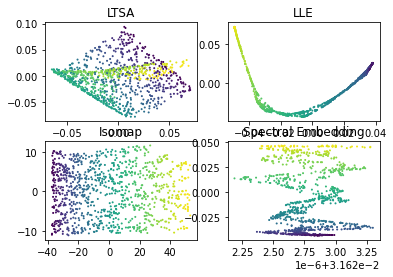

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].scatter(embed_ltsa[:, 0], embed_ltsa[:, 1], s=1, c=color)
axes[0, 0].set_title('LTSA')
axes[0, 1].scatter(embed_lle[:, 0], embed_lle[:, 1], s=1, c=color)
axes[0, 1].set_title('LLE')
axes[1, 0].scatter(embed_isomap[:, 0], embed_isomap[:, 1], s=1, c=color)
axes[1, 0].set_title('Isomap')
axes[1, 1].scatter(embed_spectral[:, 0], embed_spectral[:, 1], s=1, c=color)
axes[1, 1].set_title('Spectral Embedding')
plt.show()

# Riemannian metric

To compute a R. Metric you will need an embedding and a Laplacian.

If you plan to estimate the Riemannian Metric then when you compute the Laplacian for best results you should use **laplacian_method = 'geometric'** and set the keyword parameter 'scaling_epps' to the 'radius' that was used in the affinity method.

In [21]:
geom.laplacian_method = 'geometric'
geom.laplacian_kwds = {'scaling_epps':radius} # scaling ensures convergence to Laplace-Beltrami operator
laplacian_matrix = geom.compute_laplacian_matrix()

In [22]:
# Estimate Riemannian metric for all four methods
# from megaman.geometry.rmetric import RiemannMetric

rmetric_spectral = RiemannMetric(embed_spectral, geom.laplacian_matrix)
H_spectral = rmetric_spectral.get_dual_rmetric()

rmetric_ltsa = RiemannMetric(embed_ltsa, geom.laplacian_matrix)
H_ltsa = rmetric_ltsa.get_dual_rmetric()

rmetric_lle = RiemannMetric(embed_lle, geom.laplacian_matrix)
H_lle = rmetric_lle.get_dual_rmetric()

rmetric_isomap = RiemannMetric(embed_isomap, geom.laplacian_matrix)
H_isomap = rmetric_isomap.get_dual_rmetric()

In [23]:
print(H_isomap) # N*3*3 array

[[[ 6.7526191   0.96462542]
  [ 0.96462542  4.68210953]]

 [[ 5.9345417  -0.19650641]
  [-0.19650641  2.42663789]]

 [[ 4.94552692  0.95241149]
  [ 0.95241149  2.68121112]]

 ...

 [[ 7.11742579  1.55029156]
  [ 1.55029156  6.69123537]]

 [[ 4.77016261  0.79789467]
  [ 0.79789467  5.19856468]]

 [[ 3.20463804  0.3624669 ]
  [ 0.3624669   2.42188714]]]


In [24]:
print(rmetric_isomap.get_mdimG())

2


In [25]:
rmetric_isomap.get_rmetric() # N*2*2 array

array([[[ 0.15258129, -0.03143536],
        [-0.03143536,  0.22005537]],

       [[ 0.16895805,  0.01368203],
        [ 0.01368203,  0.41320076]],

       [[ 0.2170509 , -0.07710015],
        [-0.07710015,  0.40035306]],

       ...,

       [[ 0.14796754, -0.03428258],
        [-0.03428258,  0.15739216]],

       [[ 0.21516024, -0.03302358],
        [-0.03302358,  0.19742937]],

       [[ 0.317421  , -0.04750618],
        [-0.04750618,  0.42001107]]])

## Plot distortion

Use the *cover_plotter* module included in megaman to plot a subset of the points as ellipses representing the distortion

In [26]:
# from megaman.utils.covar_plotter import plot_cov_ellipse
n_plot = 50
rng = np.random.RandomState(8675309)
sample_points = rng.choice(range(N), n_plot, replace = False)

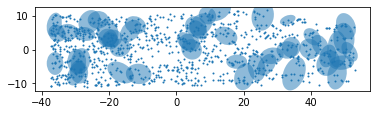

In [27]:
# Isomap
f, ax = plt.subplots()
ax.scatter(embed_isomap[:, 0], embed_isomap[:, 1], s = 1)
ax.set_aspect('equal') # if an ellipse is a circle no distortion occured. 
for i in range(n_plot):
    ii = sample_points[i]
    cov = H_isomap[ii, :, :]
    plot_cov_ellipse(cov*0.5, embed_isomap[ii, :] ,ax=ax, edgecolor='none', alpha = 0.5) # tune cov*0.1 to change the ellipse size
plt.show()

TypeError: return arrays must be of ArrayType

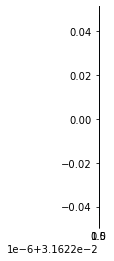

In [28]:
# Spectral embedding
f, ax = plt.subplots()
ax.scatter(embed_spectral[:, 0], embed_spectral[:, 1], s = 1)
ax.set_aspect('equal') # if an ellipse is a circle no distortion occured. 
for i in range(n_plot):
    ii = sample_points[i]
    cov = H_spectral[ii, :, :]
    plot_cov_ellipse(cov*0.01, embed_spectral[ii,:] ,ax=ax, edgecolor='none', alpha = 0.5)
plt.show()

## Adjacency matrix using FLANN with different options

*compute_adjacency_matrix* is best to use 'method' = 'cyflann'.

The 'cyflann' itself has several parameters that can be adjusted.
The 'cyflann' method defaults to 'kmeans' which has additional parameters, and it also has the 'kdtrees' option. 

In [29]:
# kmeans
import time
N = 100000
X, color = datasets.samples_generator.make_s_curve(N, random_state=0)
radius = 1.5
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kmeans', 'branching':64, 'iterations':20, 'cb_index':0.4}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)
geom.set_data_matrix(X)
t0 = time.time()
adjacency_matrix = geom.compute_adjacency_matrix()
t1 = time.time() - t0
print(t1)

AttributeError: module 'sklearn.datasets' has no attribute 'samples_generator'

In [30]:
# k-d trees, faster
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':10}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)
geom.set_data_matrix(X)
t0 = time.time()
adjacency_matrix = geom.compute_adjacency_matrix()
t1 = time.time() - t0
print(t1)

0.024318933486938477
